In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install einops
from einops import rearrange


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
fish= torchvision.io.read_image("/kaggle/input/fishhd/Fish_HD.jpg")

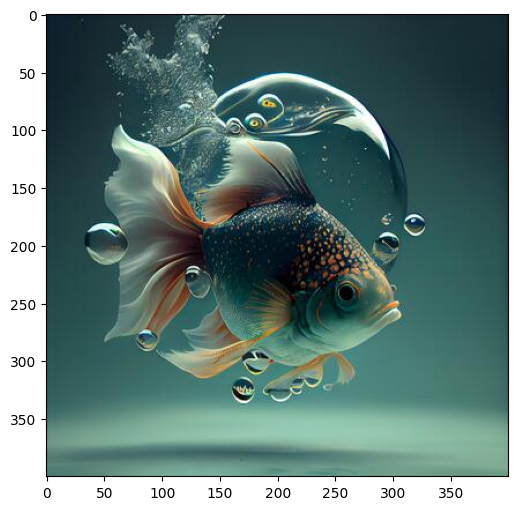

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(rearrange(fish, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(fish.reshape(-1, 1))
scaled_fish = scaler.transform(fish.reshape(-1, 1)).reshape(fish.shape)
scaled_fish = torch.tensor(scaled_fish).float().to(device)
print(scaled_fish.shape)
print(scaled_fish)
print(scaled_fish.max(), scaled_fish.min())


torch.Size([3, 400, 400])
tensor([[[0.0431, 0.0471, 0.0510,  ..., 0.0784, 0.0745, 0.0706],
         [0.0431, 0.0471, 0.0510,  ..., 0.0784, 0.0745, 0.0706],
         [0.0431, 0.0471, 0.0510,  ..., 0.0784, 0.0745, 0.0706],
         ...,
         [0.2980, 0.3020, 0.3059,  ..., 0.4235, 0.4275, 0.4235],
         [0.2941, 0.2980, 0.3020,  ..., 0.4118, 0.4196, 0.4118],
         [0.2941, 0.2980, 0.3020,  ..., 0.4118, 0.4118, 0.4118]],

        [[0.1059, 0.1098, 0.1137,  ..., 0.1529, 0.1490, 0.1451],
         [0.1059, 0.1098, 0.1137,  ..., 0.1529, 0.1490, 0.1451],
         [0.1059, 0.1098, 0.1137,  ..., 0.1529, 0.1490, 0.1451],
         ...,
         [0.4745, 0.4784, 0.4824,  ..., 0.6157, 0.6118, 0.6157],
         [0.4706, 0.4745, 0.4784,  ..., 0.6157, 0.6118, 0.6157],
         [0.4706, 0.4745, 0.4784,  ..., 0.6157, 0.6157, 0.6157]],

        [[0.1569, 0.1608, 0.1647,  ..., 0.1804, 0.1765, 0.1725],
         [0.1569, 0.1608, 0.1647,  ..., 0.1804, 0.1765, 0.1725],
         [0.1569, 0.1608, 0.1647

In [6]:
fish_400 = transforms.functional.crop(scaled_fish.cpu(), 0, 0, 400, 400)

(200, 200, 3)


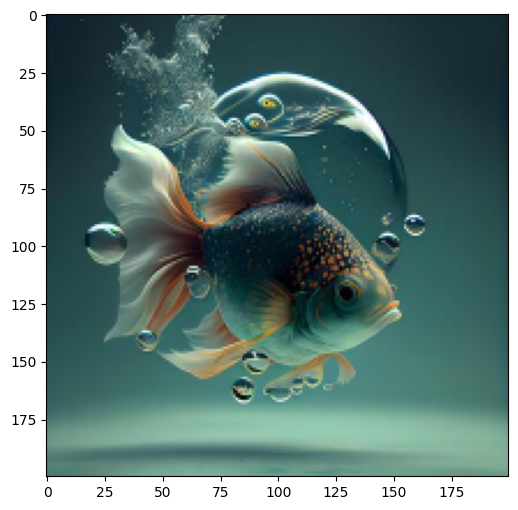

In [7]:
import cv2

fish_200 = rearrange(fish_400, 'c h w -> h w c').numpy()
fish_200 = cv2.resize(fish_200, (int(fish_200.shape[1]*0.5), int(fish_200.shape[0]*0.5)), interpolation = cv2.INTER_AREA)
print(fish_200.shape)
plt.figure(figsize=(6, 6))
plt.imshow(fish_200)

In [8]:
# Converting the 200x200 back to a torch.Tensor object
fish_200 = torch.tensor(fish_200, dtype=torch.float16).permute(2,0,1).to(device)
print(fish_200.shape)
print(fish_200.min(), fish_200.max())
fish_200

torch.Size([3, 200, 200])
tensor(0., dtype=torch.float16) tensor(1., dtype=torch.float16)


tensor([[[0.0451, 0.0529, 0.0608,  ..., 0.0883, 0.0804, 0.0726],
         [0.0451, 0.0529, 0.0608,  ..., 0.0883, 0.0804, 0.0726],
         [0.0451, 0.0529, 0.0608,  ..., 0.0883, 0.0804, 0.0726],
         ...,
         [0.3147, 0.3215, 0.3235,  ..., 0.4656, 0.4656, 0.4656],
         [0.3010, 0.3069, 0.3118,  ..., 0.4324, 0.4324, 0.4324],
         [0.2961, 0.3040, 0.3059,  ..., 0.4138, 0.4138, 0.4138]],

        [[0.1078, 0.1157, 0.1235,  ..., 0.1627, 0.1549, 0.1471],
         [0.1078, 0.1157, 0.1235,  ..., 0.1627, 0.1549, 0.1471],
         [0.1078, 0.1157, 0.1235,  ..., 0.1627, 0.1549, 0.1471],
         ...,
         [0.4834, 0.4902, 0.4922,  ..., 0.6362, 0.6362, 0.6362],
         [0.4775, 0.4834, 0.4883,  ..., 0.6167, 0.6167, 0.6167],
         [0.4727, 0.4805, 0.4824,  ..., 0.6147, 0.6147, 0.6147]],

        [[0.1588, 0.1666, 0.1746,  ..., 0.1902, 0.1824, 0.1746],
         [0.1588, 0.1666, 0.1746,  ..., 0.1902, 0.1824, 0.1746],
         [0.1588, 0.1666, 0.1746,  ..., 0.1902, 0.1824, 0.

In [9]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Scale the dimensions of the image
    height = int(height * scale)
    width = int(width * scale)

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> h w c').float()
    return X, Y

In [10]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [11]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [12]:
def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

In [13]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    if(return_Output == 1):
        return pred_img

In [14]:
import gc
gc.collect()

365

In [15]:
# Creating the Coordinate Map of the 200x200 image
X, Y = create_coordinate_map(fish_200)
print("Shape of X =", X.shape, "\nShape of Y =", Y.shape)
print("X:\n", X, "\nY:\n", Y)

Shape of X = torch.Size([40000, 2]) 
Shape of Y = torch.Size([200, 200, 3])
X:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]]) 
Y:
 tensor([[[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        [[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        [[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        ...,

        [[0.3147, 0.4834, 0.4480],
         [0.3215, 0.4902, 0.4548],
       

In [16]:
# Scaling X using Min-Max Scaler
scaler = preprocessing.MinMaxScaler().fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)
print(scaled_X.shape)
print(scaled_X)

torch.Size([40000, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.0050],
        [0.0000, 0.0101],
        ...,
        [1.0000, 0.9899],
        [1.0000, 0.9950],
        [1.0000, 1.0000]])


In [17]:
X_rff, rff = create_rff_features(scaled_X, 37500, 0.008)
X_rff.shape

torch.Size([40000, 37500])

In [18]:
net = LinearModel(X_rff.shape[1], 3).to(device)
net

LinearModel(
  (linear): Linear(in_features=37500, out_features=3, bias=True)
)

In [19]:
Y = Y.view(-1, 3)  # Reshape Y to (40000, 3)
Y = Y.to(device)
train(net, 0.02, X_rff, Y, 1500)

Epoch 0 loss: 0.154168
Epoch 100 loss: 0.001438
Epoch 200 loss: 0.001418
Epoch 300 loss: 0.001412
Epoch 400 loss: 0.001409
Epoch 500 loss: 0.001407
Epoch 600 loss: 0.001405
Epoch 700 loss: 0.001404
Epoch 800 loss: 0.001403
Epoch 900 loss: 0.001402
Epoch 1000 loss: 0.001402
Epoch 1100 loss: 0.001401
Epoch 1200 loss: 0.001400
Epoch 1300 loss: 0.001400
Epoch 1400 loss: 0.001399


0.0013987051788717508

In [20]:
del X_rff, X, Y, scaled_X
gc.collect()

0

In [21]:
# Creating the Coordinate Map for the Super-Resolution Image (2x Scaled: 400 x 400)

X_2, Y_2 = create_coordinate_map(fish_200, scale = 2)
print("Shape of X_2 =", X_2.shape, "\nShape of Y_2 =", Y_2.shape)
print("X_2:\n", X_2,"\nY_2:\n", Y_2)


Shape of X_2 = torch.Size([160000, 2]) 
Shape of Y_2 = torch.Size([200, 200, 3])
X_2:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]]) 
Y_2:
 tensor([[[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        [[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        [[0.0451, 0.1078, 0.1588],
         [0.0529, 0.1157, 0.1666],
         [0.0608, 0.1235, 0.1746],
         ...,
         [0.0883, 0.1627, 0.1902],
         [0.0804, 0.1549, 0.1824],
         [0.0726, 0.1471, 0.1746]],

        ...,

        [[0.3147, 0.4834, 0.4480],
         [0.3215, 0.4902, 0.4548]

In [22]:
# Scaling X using Min-Max Scaler

scaler = preprocessing.MinMaxScaler().fit(X_2.cpu())
scaled_X_2 = torch.tensor(scaler.transform(X_2.cpu())).float().to(device)
print(scaled_X_2.shape)
print(scaled_X_2)

torch.Size([160000, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.0025],
        [0.0000, 0.0050],
        ...,
        [1.0000, 0.9950],
        [1.0000, 0.9975],
        [1.0000, 1.0000]])


In [23]:
# Transforming the scaled_X to the Random Fourier Features

X_rff = rff.transform(scaled_X_2.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)
print(X_rff.shape)
print(X_rff)

torch.Size([160000, 37500])
tensor([[ 0.0045, -0.0029, -0.0068,  ..., -0.0005,  0.0070, -0.0047],
        [ 0.0042, -0.0033, -0.0056,  ..., -0.0014,  0.0067, -0.0062],
        [ 0.0040, -0.0037, -0.0039,  ..., -0.0024,  0.0064, -0.0071],
        ...,
        [-0.0013,  0.0065,  0.0008,  ..., -0.0068,  0.0040,  0.0047],
        [-0.0016,  0.0067,  0.0030,  ..., -0.0063,  0.0033,  0.0028],
        [-0.0019,  0.0068,  0.0049,  ..., -0.0058,  0.0026,  0.0006]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0684447..1.082287].


torch.Size([160000, 3])


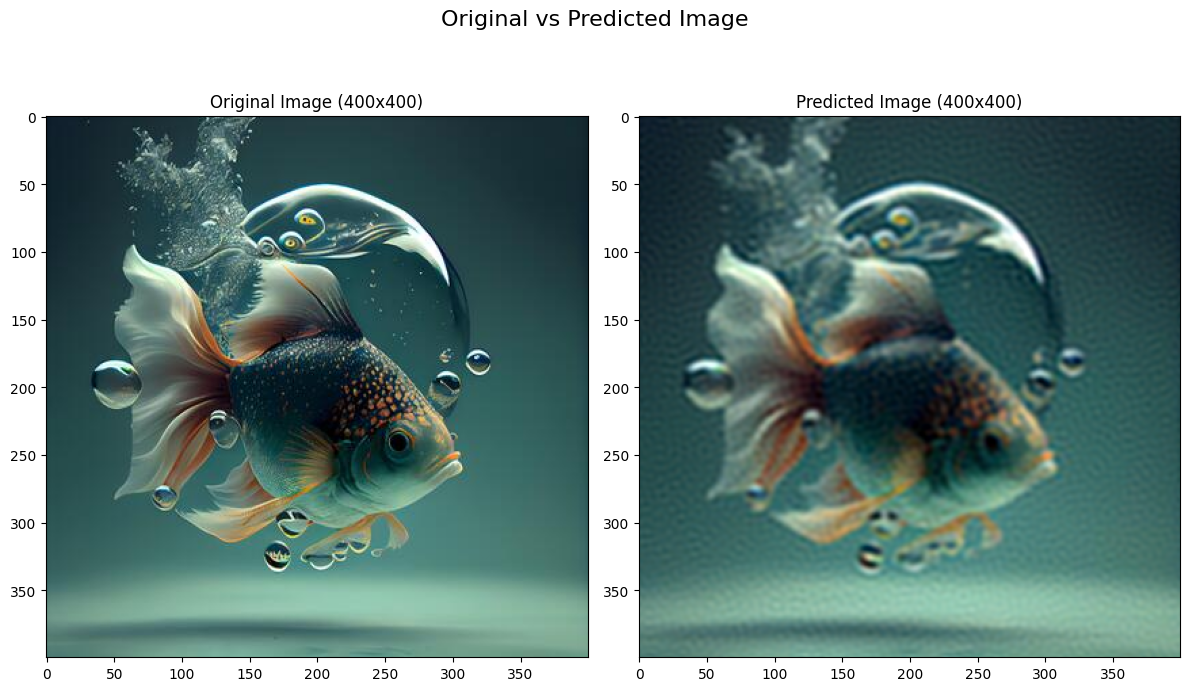

In [24]:
Y = plot_Original_vs_Predicted_Img(fish_400, X_rff, net, return_Output = 1)

In [25]:
Y = Y.to(device)
fish_400 = fish_400.to(device)

In [26]:
# Compute MSE
mse_loss = nn.MSELoss()
mse = mse_loss(Y, fish_400)
print(f"RMSE: {mse.item()**0.5:.6f}")

RMSE: 0.053642


In [27]:
# Compute PSNR
def psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0:  # Means no noise in the image
        return 100
    pixel_max = 1.0  # Assuming pixel values are normalized between 0 and 1
    return 20 * np.log10(pixel_max / np.sqrt(mse))
psnr_value = psnr(fish_400.cpu().flatten().detach().numpy(), Y.cpu().flatten().detach().numpy())
print(f"PSNR: {psnr_value:.6f} dB")

PSNR: 25.409847 dB
